In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

### Generating Dataframe

In [2]:
positive_dir = Path("/kaggle/input/surface-crack-detection/Positive")
negative_dir = Path("/kaggle/input/surface-crack-detection/Negative")



In [3]:
list(positive_dir.glob(r"*.jpg"))[:10]

[PosixPath('/kaggle/input/surface-crack-detection/Positive/08450.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/19812.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/05938.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/06122.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/08536.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/04168.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/12903_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/11742_1.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/02371.jpg'),
 PosixPath('/kaggle/input/surface-crack-detection/Positive/04377.jpg')]

In [4]:
def generate_df(images,label):
    
    records = pd.Series(list(images.glob(r"*.jpg")),name="File Path").astype(str)
    labels = pd.Series(label , name="Label", index=records.index)
    df = pd.concat([records,labels],axis=1)
    
    return df

In [5]:
positive_df = generate_df(positive_dir,"CRACK")
positive_df.head()

,File Path,Label
0,/kaggle/input/surface-crack-detection/Positive...,CRACK
1,/kaggle/input/surface-crack-detection/Positive...,CRACK
2,/kaggle/input/surface-crack-detection/Positive...,CRACK
3,/kaggle/input/surface-crack-detection/Positive...,CRACK
4,/kaggle/input/surface-crack-detection/Positive...,CRACK


In [6]:
negative_df = generate_df(negative_dir,"NO CRACK")
negative_df.head()

,File Path,Label
0,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
1,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
2,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
3,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
4,/kaggle/input/surface-crack-detection/Negative...,NO CRACK


In [7]:
df = pd.concat([positive_df,negative_df],axis=0).sample(frac=1.0,random_state=42).reset_index(drop=True)
df

,File Path,Label
0,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
1,/kaggle/input/surface-crack-detection/Positive...,CRACK
2,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
3,/kaggle/input/surface-crack-detection/Positive...,CRACK
4,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
...,...,...
39995,/kaggle/input/surface-crack-detection/Positive...,CRACK
39996,/kaggle/input/surface-crack-detection/Positive...,CRACK
39997,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
39998,/kaggle/input/surface-crack-detection/Positive...,CRACK


### Train Test Split

In [8]:
train_df,test_df = train_test_split(df.sample(5000),test_size=0.3,shuffle=True,random_state=42)

In [9]:
train_df

,File Path,Label
2726,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
33401,/kaggle/input/surface-crack-detection/Positive...,CRACK
17907,/kaggle/input/surface-crack-detection/Positive...,CRACK
37598,/kaggle/input/surface-crack-detection/Positive...,CRACK
31628,/kaggle/input/surface-crack-detection/Positive...,CRACK
...,...,...
221,/kaggle/input/surface-crack-detection/Positive...,CRACK
18660,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
17599,/kaggle/input/surface-crack-detection/Negative...,NO CRACK
12144,/kaggle/input/surface-crack-detection/Negative...,NO CRACK


In [10]:
test_df["Label"]

13423    NO CRACK
4253        CRACK
9278     NO CRACK
6741        CRACK
9933        CRACK
           ...   
10065       CRACK
535      NO CRACK
24423       CRACK
12599       CRACK
26773       CRACK
Name: Label, Length: 1500, dtype: object

### Loading Image Data

In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(

    rescale = 1./255,
    validation_split = 0.2
) 

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(

    rescale = 1./255
    
)

In [12]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = "File Path",
    y_col = "Label",
    target_size = (120,120),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "training"
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = "File Path",
    y_col = "Label",
    target_size = (120,120),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "validation"
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col = "File Path",
    y_col = "Label",
    target_size = (120,120),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = False,
    seed = 42,
   
)

Found 2800 validated image filenames belonging to 2 classes.
Found 700 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


### Training the model

In [13]:
from tensorflow.keras import Input,Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,GlobalAveragePooling2D


In [14]:
tf.random.set_seed(42)

model = Sequential([
    Conv2D(filters=16,kernel_size=(3,3),activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16,kernel_size=(3,3),activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    GlobalAveragePooling2D(),
    Dense(1,activation="sigmoid"),
])


model.compile(optimizer = "adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])



In [15]:
history = model.fit(train_data,
                   validation_data = val_data,
                   epochs=100,
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(
                       monitor="val_loss",
                       patience =5,
                       restore_best_weights = True)
                   ])

Epoch 1/100
88/88 [==============================] - 22s 234ms/step - loss: 0.6766 - accuracy: 0.6836 - val_loss: 0.6501 - val_accuracy: 0.8443
Epoch 2/100
88/88 [==============================] - 19s 214ms/step - loss: 0.6239 - accuracy: 0.7264 - val_loss: 0.5684 - val_accuracy: 0.8443
Epoch 3/100
88/88 [==============================] - 18s 209ms/step - loss: 0.5649 - accuracy: 0.7461 - val_loss: 0.5207 - val_accuracy: 0.7900
Epoch 4/100
88/88 [==============================] - 19s 212ms/step - loss: 0.5080 - accuracy: 0.8364 - val_loss: 0.4402 - val_accuracy: 0.9014
Epoch 5/100
88/88 [==============================] - 18s 209ms/step - loss: 0.4368 - accuracy: 0.8904 - val_loss: 0.3693 - val_accuracy: 0.9229
Epoch 6/100
88/88 [==============================] - 18s 200ms/step - loss: 0.3789 - accuracy: 0.9007 - val_loss: 0.3125 - val_accuracy: 0.9286
Epoch 7/100
88/88 [==============================] - 18s 202ms/step - loss: 0.3288 - accuracy: 0.9218 - val_loss: 0.2744 - val_accuracy:

### Evaluation

In [25]:
model.predict(test_data)

47/47 [==============================] - 5s 97ms/step


array([[9.8990005e-01],
       [4.0560386e-09],
       [9.9018115e-01],
       ...,
       [5.1661325e-05],
       [3.0862109e-06],
       [6.9096917e-05]], dtype=float32)

In [17]:
def evaluaclasseste_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NO CRACK", "CRACK"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NO CRACK", "CRACK"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n", clr)

    Test Loss: 0.05780
Test Accuracy: 97.80%
47/47 [==============================] - 4s 91ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


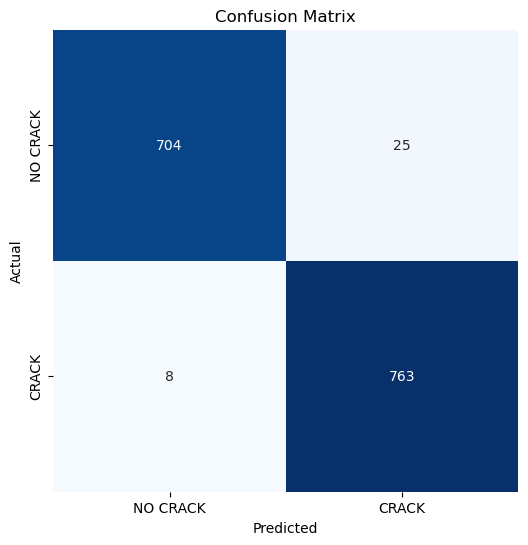

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.97      0.98       729
    POSITIVE       0.97      0.99      0.98       771

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [18]:
evaluate_model(model, test_data)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 16)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                        

In [26]:
model.save("detection_model1.h5")